In [1]:
import os
import re
import json
import time
import collections
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pprint import pprint
from customer_behaviour.tools.cluster import Cluster
from customer_behaviour.tools.result import Result
from customer_behaviour.tools import dgm as dgm
from customer_behaviour.tools.time_series_analysis import FeatureExtraction
from IPython.display import Javascript

In [2]:
# Load super class
Javascript('Jupyter.notebook.execute_cells([-1])')

<IPython.core.display.Javascript object>

In [ ]:
# Load cases
#Javascript('Jupyter.notebook.execute_cells([-2])')


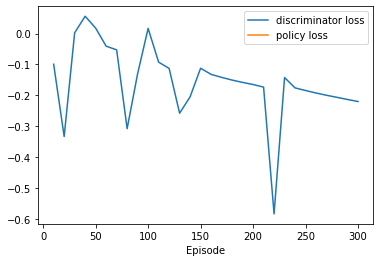

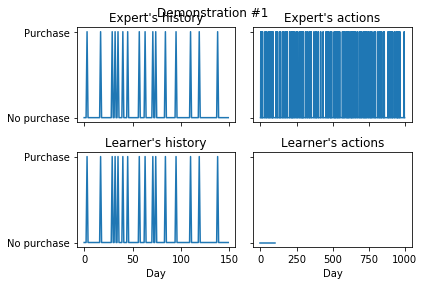

In [5]:
datetime = '2020-02-20_09-18-42'
dir_path = '/results/gail/discrete_events/1_expert(s)/case_2/' + datetime

result = Case2(dir_path)
result.plot_loss()
result.plot_trajectories(n_trajectories = None)
# result.compare_trajectories()

In [3]:
############################
########## Case 3 ##########
############################

class Case3(Result):
    # There is only one expert
    # State representation: [days elapsed since last purchase, 
    #                        days elapsed between last purchase and the purchase before that, ...]
    
    def __init__(self, dir_path):
        Result.__init__(self, dir_path)
        
        self.n_expert_trajectories = self.expert_states.shape[0]
        
        self.n_learner_trajectories, self.episode_length, _ = self.learner_states.shape
        self.n_historical_events = self.learner_states.shape[2]
        self.agent_features = self.get_features()
        self.expert_features = self.get_features(expert = True)
        cluster = Cluster(self.agent_features, self.expert_features)
        self.mean_dist, self.min_dist, self.max_dist = cluster.get_dist_between_clusters()
        #self.dist_between_clusters = self.get_dist_between_clusters(self.expert_features, self.agent_features)
        
    def get_features(self, n_trajectories=None, expert=False):
        if n_trajectories is None: 
            n_trajectories = self.n_expert_trajectories if expert else self.n_learner_trajectories
        features_ls = []
        for i in range(n_trajectories):
            if expert:
                states = self.expert_states[i]
                actions = self.expert_actions[i]
            else:
                states = self.learner_states[i]
                actions = self.learner_actions[i]
                
            tsa = FeatureExtraction(actions, case='discrete_events')
            features = tsa.get_features()
            #mean_freq, std_freq = tsa.get_mean_std_freq()
            #min_elapsed_days, max_elapsed_days = tsa.get_min_max_elapsed_days()

            #features = [round(mean_freq[0], 2), round(std_freq[0], 2), \
            #            min_elapsed_days[0], max_elapsed_days[0]]
  
            features_ls.append(features)
        return features_ls
        
    def compare_trajectories(self, n_trajectories=None):
        expert_states = self.expert_states[0]
        expert_actions = self.expert_actions[0]
        expert_history = self.get_history(expert_states[0])
        
        if n_trajectories is None: n_trajectories = self.n_learner_trajectories
        
        for i in range(n_trajectories):
            states = self.learner_states[i]
            actions = self.learner_actions[i]
            history = self.get_history(states[0])
                
            fig = self.plot(expert_history, expert_actions, history, actions)  
            fig.suptitle('Demonstration #{}'.format(i+1))
                         
        fig.tight_layout()
        plt.show()
    
    def plot_trajectories(self, n_trajectories=None, expert=False):
        if n_trajectories is None: 
            n_trajectories = self.n_expert_trajectories if expert else self.n_learner_trajectories
        
        for i in range(n_trajectories):
            if expert:
                states = self.expert_states[i]
                actions = self.expert_actions[i]
            else:
                states = self.learner_states[i]
                actions = self.learner_actions[i]
            
            history = self.get_history(states[0])
            
            fig = self.plot(history, actions, expert)
            
            fig.suptitle('mean_dist: %.1f, min_dist: %.1f, max_dist: %.1f' %(self.mean_dist, self.min_dist, self.max_dist))
            
        plt.show()
        fig.tight_layout()      
        
        
    def get_history(self, initial_state):
        history = []
        for x in initial_state:
            while x > 1:
                history.append(0)
                x -= 1
            history.append(1)
        history.reverse()
        return history
    
    '''           
    def plot(self, history, actions, expert=False):
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row')
        ax1.plot(history)
        ax2.plot(actions)
            
        # Set titles
        if expert:
            ax1.set_title("Expert's history")
            ax2.set_title("Expert's actions")
        else:
            ax1.set_title("Learner's history")
            ax2.set_title("Learner's actions")
            
        # Set x-labels
        ax1.set_xlabel('Day')
        ax2.set_xlabel('Day')

        # Set y-labels
        ax1.set_yticks([0, 1])
        ax1.set_yticklabels(['No purchase', 'Purchase'])
        
        return fig
    '''

############################
########## Case 2 ##########
############################ 

class Case2(Result):
    # There is only one expert
    # State representation: [historical purchases]
    
    def __init__(self, dir_path):
        Result.__init__(self, dir_path) 
        
        self.n_learner_trajectories, self.episode_length, _ = self.learner_states.shape
        self.n_historical_events = self.learner_states.shape[2]
    
    def plot_trajectories(self, n_trajectories=None):
        expert_states = self.expert_states[0]
        expert_actions = self.expert_actions[0]
        expert_history = expert_states[0][:]
        
        if n_trajectories is None: n_trajectories = self.n_learner_trajectories
        
        for i in range(n_trajectories):
            states = self.learner_states[i]
            actions = self.learner_actions[i]
            history = states[0][:]
                
            fig = self.plot(expert_history, expert_actions, history, actions)  
            fig.suptitle('Demonstration #{}'.format(i+1))
                         
        fig.tight_layout()
        plt.show()

############################
########## Case 1 ##########
############################
        
class Case1(Result):
    # There is only one expert
    # State representation: [sex, age, historical purchases]
    
    def __init__(self, dir_path):
        Result.__init__(self, dir_path) 
        
        # assert self.expert_states.shape[0] == 1
        
        self.n_learner_trajectories, self.episode_length, _ = self.learner_states.shape
        self.n_historical_events = self.learner_states.shape[2] - 2
    
    def plot_trajectories(self, n_trajectories=None):
        expert_states = self.expert_states[0]
        expert_actions = self.expert_actions[0]
        expert_sex = expert_states[0][0]
        expert_age = expert_states[0][1]
        expert_history = expert_states[0][2:]
        
        if n_trajectories is None: n_trajectories = self.n_learner_trajectories
        
        for i in range(n_trajectories):
            states = self.learner_states[i]
            actions = self.learner_actions[i]
            sex = states[0][0]
            age = states[0][1]
            history = states[0][2:]
            
            expert_sex_str = 'female' if expert_sex == 1 else 'male'
            sex_str = 'female' if sex == 1 else 'male'
            text = 'Expert: {}, {} years old | Learner: {}, {} years old'.format(
                expert_sex_str, get_age(expert_age), sex_str, get_age(age))
                
            fig = self.plot(expert_history, expert_actions, history, actions)  
            fig.suptitle('Demonstration #{}'.format(i+1))
            fig.text(0.5, 0, text, horizontalalignment='center', verticalalignment='center')
                         
        fig.tight_layout()
        plt.show()
